<a href="https://colab.research.google.com/github/khushichodnekar/OnlineFraudDetection/blob/main/ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the dataset...
Dataset shape: (6362620, 11)
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
First few rows of the dataset:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671    

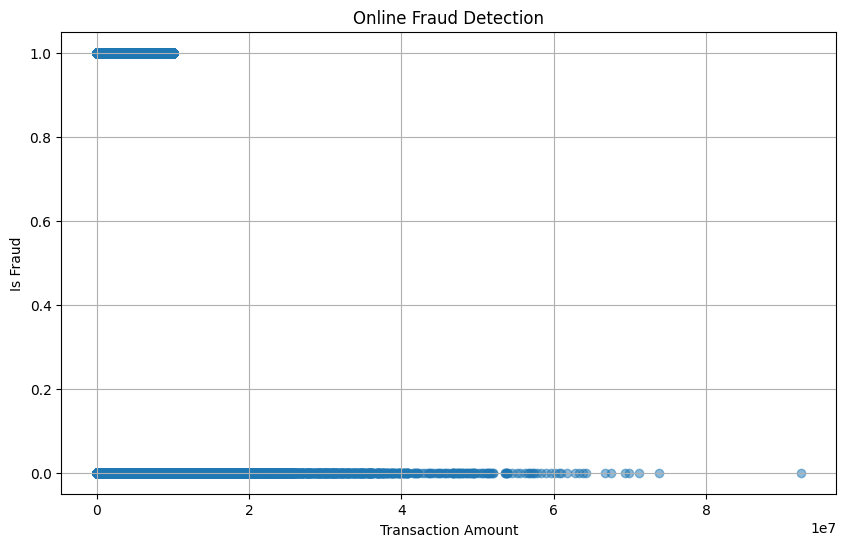

Reduced dataset shape: (63626, 11)
Creating new features...
Defining features and target...
Handling categorical columns...
Starting one-hot encoding...
One-hot encoding successful. Shape of encoded columns: (63626, 5)
Combining encoded categorical columns with numeric columns...
Shape of X_combined: (63626, 15)
Data types:
step                                   int64
amount                               float64
oldbalanceOrg                        float64
newbalanceOrig                       float64
oldbalanceDest                       float64
newbalanceDest                       float64
balanceDiffOrig                      float64
balanceDiffDest                      float64
transactionPercentage                float64
logAmount                            float64
type_CASH_IN             Sparse[bool, False]
type_CASH_OUT            Sparse[bool, False]
type_DEBIT               Sparse[bool, False]
type_PAYMENT             Sparse[bool, False]
type_TRANSFER            Sparse[bool, False]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Predictions for the test set:
[0 0 0 ... 1 0 0]
Classification Report for SVM:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     15881
           1       0.04      0.96      0.09        26

    accuracy                           0.97     15907
   macro avg       0.52      0.96      0.53     15907
weighted avg       1.00      0.97      0.98     15907

Confusion Matrix for SVM:
[[15345   536]
 [    1    25]]


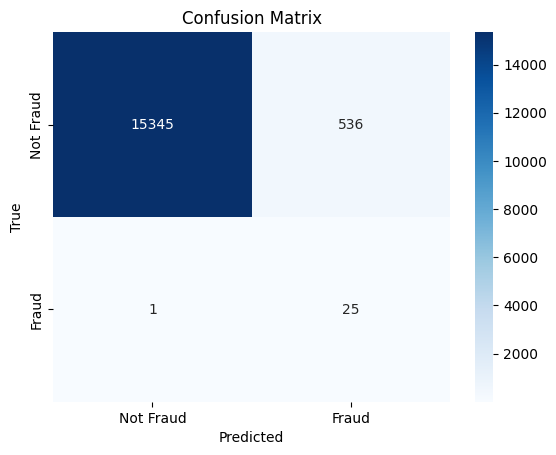

ROC-AUC Score: 0.9930904370486261
Model saved as svm_fraud_model.pkl
Comparison of Actual vs Predicted:
         Actual  Predicted
4301309       0          0
3647835       0          0
987575        0          0
747524        0          0
1050456       0          0
2344594       0          0
269181        0          0
4002122       0          0
2592417       0          0
2073739       0          0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib
from sklearn.svm import SVC
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Load the dataset
print("Loading the dataset...")
dataset = pd.read_csv('/content/drive/MyDrive/onlinefraud.csv')
print("Dataset shape:", dataset.shape)
print("Dataset info:")
print(dataset.info())

# Display the first few rows to understand the structure
print("\nFirst few rows of the dataset:")
print(dataset.head())

# Plot the relationship between transaction amount and fraud
plt.figure(figsize=(10, 6))
plt.scatter(dataset['amount'], dataset['isFraud'], alpha=0.5)
plt.title("Online Fraud Detection")
plt.xlabel("Transaction Amount")
plt.ylabel("Is Fraud")
plt.grid()
plt.show()


# For initial testing, reduce the dataset size further
dataset = dataset.sample(frac=0.01, random_state=0)  # Use only 1% of the data
print("\nReduced dataset shape:", dataset.shape)

# Create new features
print("\nCreating new features...")
dataset['balanceDiffOrig'] = dataset['oldbalanceOrg'] - dataset['newbalanceOrig']
dataset['balanceDiffDest'] = dataset['oldbalanceDest'] - dataset['newbalanceDest']
dataset['transactionPercentage'] = dataset['amount'] / (dataset['oldbalanceOrg'] + 1)  # Add 1 to avoid division by zero
dataset['logAmount'] = np.log1p(dataset['amount'])  # Log transform the amount

# Define features (X) and target (Y)
print("\nDefining features and target...")
X = dataset.drop(['isFraud', 'isFlaggedFraud'], axis=1)  # Remove target columns
Y = dataset['isFraud']  # Target column

# Handle categorical columns
print("\nHandling categorical columns...")
categorical_cols = ['type']  # Only encode the 'type' column

# One-hot encoding for categorical columns
print("Starting one-hot encoding...")
X_categorical_encoded = pd.get_dummies(X[categorical_cols], sparse=True)
print("One-hot encoding successful. \nShape of encoded columns:", X_categorical_encoded.shape)

# Combine encoded categorical columns with numeric columns
print("Combining encoded categorical columns with numeric columns...")
X_numeric = X.drop(categorical_cols + ['nameOrig', 'nameDest'], axis=1)  # Drop 'nameOrig' and 'nameDest'
X_combined = pd.concat([X_numeric, X_categorical_encoded], axis=1)

# Check the shape of the combined DataFrame
print("Shape of X_combined:", X_combined.shape)

# Check data types and missing values
print("Data types:")
print(X_combined.dtypes)
print("Missing values:")
print(X_combined.isnull().sum())

# Split the dataset into training and testing sets
print("\nSplitting the dataset into training and testing sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X_combined, Y, test_size=0.25, random_state=0)
print("\nShapes after split:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

# Handle class imbalance using SMOTE
print("\nApplying SMOTE to handle class imbalance...")
smote = SMOTE(random_state=0)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
print("After SMOTE, X_train shape:", X_train_resampled.shape)
print("After SMOTE, Y_train shape:", Y_train_resampled.shape)

# Feature scaling
print("\nScaling the features...")
sc = StandardScaler(with_mean=False)  # Adjust StandardScaler for sparse data
X_train_scaled = sc.fit_transform(X_train_resampled)
X_test_scaled = sc.transform(X_test)

# Output the lengths of the training and testing sets
print("Length of X_train:", len(X_train_scaled))
print("Length of X_test:", len(X_test_scaled))

# Print shapes to verify correctness
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)
print("Shape of Y_train:", Y_train_resampled.shape)
print("Shape of Y_test:", Y_test.shape)

# SVM Model
print("\nTraining the SVM model...")
svm_model = SVC(probability=True, random_state=0)
svm_model.fit(X_train_scaled, Y_train_resampled)
Y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluation
print("\nPredictions for the test set:")
print(Y_pred_svm)

print("Classification Report for SVM:")
print(classification_report(Y_test, Y_pred_svm))

print("Confusion Matrix for SVM:")
conf_matrix = confusion_matrix(Y_test, Y_pred_svm)
print(conf_matrix)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC-AUC Score
roc_auc_svm = roc_auc_score(Y_test, svm_model.predict_proba(X_test_scaled)[:, 1])
print("ROC-AUC Score:", roc_auc_svm)

# Save the model
joblib.dump(svm_model, 'svm_fraud_model.pkl')
print("Model saved as svm_fraud_model.pkl")

# Optional: Comparison of Actual vs Predicted
results = pd.DataFrame({
    'Actual': Y_test,
    'Predicted': Y_pred_svm
})
print("Comparison of Actual vs Predicted:")
print(results.head(10))  # Display the first 10 results